# 以LSTM/GRU演算法預測股價

In [26]:
# 載入相關套件
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# 載入測試資料 -- 亞馬遜
dataset = pd.read_csv('./RNN/AMZN_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [22]:
dataset.tail()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-12-22,1172.08,1174.62,1167.83,1168.36,1585054,AMZN
2017-12-26,1168.36,1178.32,1160.55,1176.76,2005187,AMZN
2017-12-27,1179.91,1187.29,1175.61,1182.26,1867208,AMZN
2017-12-28,1189.00,1190.10,1184.38,1186.10,1841676,AMZN
2017-12-29,1182.35,1184.00,1167.50,1169.47,2688391,AMZN


In [30]:
# 資料轉換函數
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))

# 載入資料函數
def load_data(datasetname, column, seq_len, normalise_window):
    data = datasetname.loc[:,column]

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        #result = sc.fit_transform(result)
        result = normalise_windows(result)

    result = np.array(result)

    #Last 10% is used for validation test, first 90% for training
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show() 
    
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

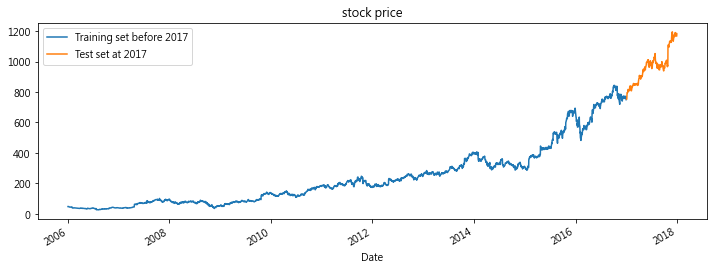

In [24]:
# 載入測試資料
Enrol_window = 100  # 預測資料視窗
feature_train, label_train, feature_test, label_test = \
    load_data(dataset, 'Close', Enrol_window, True)

# 繪圖
dataset["Close"][:'2016'].plot(figsize=(12,4),legend=True)
dataset["Close"]['2017':].plot(figsize=(12,4),legend=True) 
plt.legend(['Training set before 2017','Test set at 2017'])
plt.title('stock price')
plt.show()

In [27]:
# 訓練模型
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))
model.compile(loss='mse', optimizer='adam')
model.fit(feature_train, label_train, batch_size=512, epochs=5, 
          validation_data = (feature_test, label_test))

Epoch 1/5
6/6 [==============================] - 5s 199ms/step - loss: 0.0572 - val_loss: 0.0118
Epoch 2/5
6/6 [==============================] - 0s 56ms/step - loss: 0.0138 - val_loss: 0.0020
Epoch 3/5
6/6 [==============================] - 0s 54ms/step - loss: 0.0080 - val_loss: 0.0015
Epoch 4/5
6/6 [==============================] - 0s 55ms/step - loss: 0.0055 - val_loss: 0.0011
Epoch 5/5
6/6 [==============================] - 0s 57ms/step - loss: 0.0047 - val_loss: 0.0011


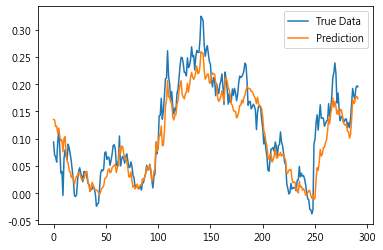

In [28]:
# 模型評估
predicted_stock_price = model.predict(feature_test)
plot_results(predicted_stock_price,label_test)

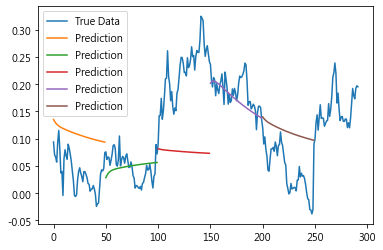

In [31]:
predictions = predict_sequences_multiple(model, feature_test, Enrol_window, 50)
plot_results_multiple(predictions, label_test, 50)  